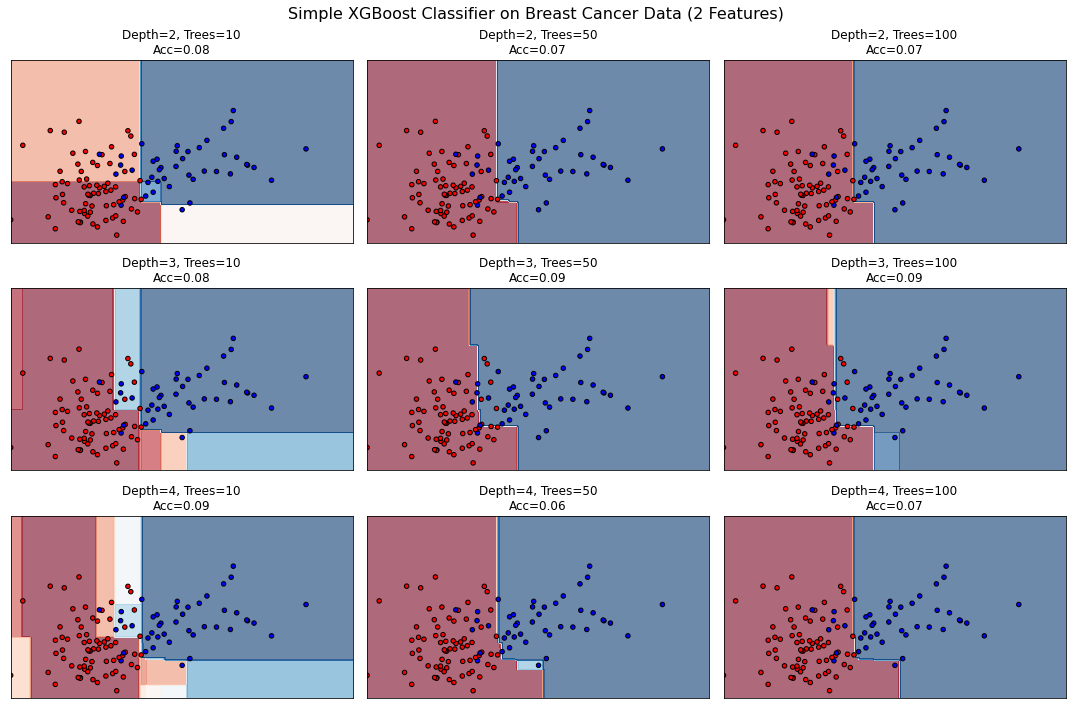

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Numerically stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree Class ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.tree = None

    def fit(self, X, grad, hess, depth=0):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = X[:, feature] <= t
                right = X[:, feature] > t
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * ((G_L + G_R)**2 / (H_L + H_R + self.lambda_))

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        left = X[:, best_feature] <= best_split
        right = X[:, best_feature] > best_split
        left_tree = self.fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self.fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        if x[feature] <= split:
            return self.predict_row(x, left)
        else:
            return self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])


# --- Boosted Model Class ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.trees = []

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        y_pred = np.zeros_like(y, dtype=float)
        self.trees = []

        for _ in range(self.n_estimators):
            p = self.sigmoid(y_pred)
            grad = p - y
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(max_depth=self.max_depth, lambda_=self.lambda_)
            tree.tree = tree.fit(X, grad, hess)
            update = tree.predict(X)

            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Load real data: Breast cancer dataset ---
data = load_breast_cancer()
X, y = data.data, data.target

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Use only first two features for 2D visualization
X_vis = X[:, :2]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X_vis, y, test_size=0.2, random_state=42)

# --- Try different combinations of estimators and depth ---
depths = [2, 3, 4]
estimators = [10, 50, 100]

fig, axes = plt.subplots(len(depths), len(estimators), figsize=(15, 10), sharex=True, sharey=True)
xx, yy = np.meshgrid(np.linspace(X_vis[:, 0].min(), X_vis[:, 0].max(), 200),
                     np.linspace(X_vis[:, 1].min(), X_vis[:, 1].max(), 200))
grid = np.c_[xx.ravel(), yy.ravel()]

for i, max_depth in enumerate(depths):
    for j, n_estimators in enumerate(estimators):
        ax = axes[i, j]
        model = SimpleXGBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=0.1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = np.mean(y_pred == y_test)

        # Decision surface
        probs = model.predict_proba(grid).reshape(xx.shape)
        ax.contourf(xx, yy, probs, levels=20, cmap="RdBu", alpha=0.6)
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="bwr", edgecolor='k', s=20)

        ax.set_title(f"Depth={max_depth}, Trees={n_estimators}\nAcc={acc:.2f}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle("Simple XGBoost Classifier on Breast Cancer Data (2 Features)", fontsize=16)
plt.tight_layout()
plt.show()


#### Until cell [22] the performance (time and accuracy) of simple xgboost is terrible. I added a bunch of optimizations, and it eventually got awesome (in cell 22 if you want to move ahead). I used a scaler, clipped tree outputs, regularization, at some point I'm using a stable_sigmoid because the regular one was giving me an overlfow. I used Subsampling + Colsample_bytree to randomly sample both data points and features per tree to: Reduce overfitting and speed up training. I'm not sure if these mess up the ZK part but without them the performance was not ok.

In [13]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree class ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.tree = None

    def fit(self, X, grad, hess, depth=0):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = X[:, feature] <= t
                right = X[:, feature] > t
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * ((G_L + G_R)**2 / (H_L + H_R + self.lambda_))

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        left = X[:, best_feature] <= best_split
        right = X[:, best_feature] > best_split
        left_tree = self.fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self.fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        if x[feature] <= split:
            return self.predict_row(x, left)
        else:
            return self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Boosted model class ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.trees = []

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        y_pred = np.zeros_like(y, dtype=float)
        self.trees = []

        for _ in range(self.n_estimators):
            p = self.sigmoid(y_pred)
            grad = p - y
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(max_depth=self.max_depth, lambda_=self.lambda_)
            tree.tree = tree.fit(X, grad, hess)
            update = tree.predict(X)

            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Load and prep data ---
data = load_breast_cancer()
X, y = data.data, data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Try different parameter combinations ---
depths = [2, 3, 4, 5]
estimators = [10, 50, 100]

print("Training SimpleXGBoost on Breast Cancer Dataset (full features)\n")

for max_depth in depths:
    for n_estimators in estimators:
        model = SimpleXGBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=0.1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"Depth={max_depth}, Estimators={n_estimators} → Accuracy: {accuracy:.4f}")


Training SimpleXGBoost on Breast Cancer Dataset (full features)

Depth=2, Estimators=10 → Accuracy: 0.0877
Depth=2, Estimators=50 → Accuracy: 0.0789
Depth=2, Estimators=100 → Accuracy: 0.0877
Depth=3, Estimators=10 → Accuracy: 0.0526
Depth=3, Estimators=50 → Accuracy: 0.0439
Depth=3, Estimators=100 → Accuracy: 0.0439
Depth=4, Estimators=10 → Accuracy: 0.0526
Depth=4, Estimators=50 → Accuracy: 0.0526
Depth=4, Estimators=100 → Accuracy: 0.0526
Depth=5, Estimators=10 → Accuracy: 0.0526
Depth=5, Estimators=50 → Accuracy: 0.0439
Depth=5, Estimators=100 → Accuracy: 0.0439


In [16]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import xgboost as xgb

# --- Install xgboost and tqdm if needed ---
# !pip install xgboost tqdm

# --- Numerically stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- SimpleXGBoost Tree ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.tree = None

    def fit(self, X, grad, hess, depth=0):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = X[:, feature] <= t
                right = X[:, feature] > t
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * ((G_L + G_R)**2 / (H_L + H_R + self.lambda_))

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        left = X[:, best_feature] <= best_split
        right = X[:, best_feature] > best_split
        left_tree = self.fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self.fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        if x[feature] <= split:
            return self.predict_row(x, left)
        else:
            return self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Simple Boosted Classifier ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.trees = []

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        y_pred = np.zeros_like(y, dtype=float)
        self.trees = []

        for _ in range(self.n_estimators):
            p = self.sigmoid(y_pred)
            grad = p - y
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(max_depth=self.max_depth, lambda_=self.lambda_)
            tree.tree = tree.fit(X, grad, hess)
            update = tree.predict(X)

            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Load and scale breast cancer dataset ---
data = load_breast_cancer()
X, y = data.data, data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Hyperparameter grid ---
depths = [2, 3, 4]
estimators = [10, 50, 100]
learning_rates = [0.01, 0.1, 0.3]

# --- Run comparisons ---
print("Benchmarking SimpleXGBoost vs XGBoost on Breast Cancer Dataset\n")

from time import time
from tqdm.notebook import tqdm

param_grid = [(d, e, lr) for d in depths for e in estimators for lr in learning_rates]

results = []

for max_depth, n_estimators, lr in tqdm(param_grid, desc="Grid Search"):
    # --- Train SimpleXGBoost ---
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr
    )
    t0 = time()
    simple_model.fit(X_train, y_train)
    simple_pred = simple_model.predict(X_test)
    simple_acc = np.mean(simple_pred == y_test)
    simple_time = time() - t0

    # --- Train real XGBoost ---
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        eval_metric="logloss",
        verbosity=0
    )
    t1 = time()
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_acc = np.mean(xgb_pred == y_test)
    xgb_time = time() - t1

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "simple_acc": simple_acc,
        "simple_time": simple_time,
        "xgb_acc": xgb_acc,
        "xgb_time": xgb_time,
    })

# --- Print comparison ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} | {'Simple Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'XGB Time'}")
print("-" * 70)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} | {r['simple_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['xgb_time']:.2f}")


Benchmarking SimpleXGBoost vs XGBoost on Breast Cancer Dataset



Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]


Depth Trees  LR    | Simple Acc  XGB Acc  | Simple Time  XGB Time
----------------------------------------------------------------------
2     10     0.01  | 0.0702      0.9561   | 6.79         0.01
2     10     0.10  | 0.0877      0.9561   | 7.03         0.01
2     10     0.30  | 0.0877      0.9561   | 7.01         0.01
2     50     0.01  | 0.0702      0.9561   | 35.48        0.03
2     50     0.10  | 0.0789      0.9561   | 35.54        0.02
2     50     0.30  | 0.0877      0.9649   | 34.32        0.03
2     100    0.01  | 0.0877      0.9561   | 69.48        0.05
2     100    0.10  | 0.0877      0.9649   | 69.70        0.08
2     100    0.30  | 0.0789      0.9737   | 68.79        0.04
3     10     0.01  | 0.0614      0.9386   | 10.07        0.01
3     10     0.10  | 0.0526      0.9561   | 10.03        0.01
3     10     0.30  | 0.0263      0.9561   | 10.04        0.01
3     50     0.01  | 0.0614      0.9561   | 51.46        0.03
3     50     0.10  | 0.0439      0.9561   | 51.21       

In [18]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return value

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            return -np.sum(grad) / (np.sum(hess) + self.lambda_)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Boosted Classifier ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        y_pred = np.zeros_like(y, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Dataset prep ---
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search ---
depths = [2, 3, 4]
estimators = [10, 50, 100]
learning_rates = [0.01, 0.1, 0.3]

param_grid = [(d, e, lr) for d in depths for e in estimators for lr in learning_rates]

results = []
print("\nRunning benchmark...")

for max_depth, n_estimators, lr in tqdm(param_grid, desc="Grid Search"):
    # Simple XGBoost
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    # Real XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        use_label_encoder=False,
        verbosity=0
    )
    t1 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t1

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "simple_acc": simple_acc,
        "simple_time": simple_time,
        "xgb_acc": xgb_acc,
        "xgb_time": xgb_time,
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} | {'Simple Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'XGB Time'}")
print("-" * 70)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} | {r['simple_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['xgb_time']:.2f}")



Running benchmark...


Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    | Simple Acc  XGB Acc  | Simple Time  XGB Time
----------------------------------------------------------------------
2     10     0.01  | 0.0439      0.9561   | 4.16         0.01
2     10     0.10  | 0.0439      0.9561   | 4.68         0.01
2     10     0.30  | 0.0526      0.9561   | 4.48         0.01
2     50     0.01  | 0.0439      0.9561   | 20.72        0.03
2     50     0.10  | 0.0614      0.9561   | 20.62        0.02
2     50     0.30  | 0.0614      0.9649   | 20.59        0.02
2     100    0.01  | 0.0526      0.9561   | 40.98        0.03
2     100    0.10  | 0.0702      0.9561   | 41.03        0.03
2     100    0.30  | 0.0526      0.9737   | 41.04        0.03
3     10     0.01  | 0.0526      0.9561   | 6.06         0.01
3     10     0.10  | 0.0263      0.9561   | 6.05         0.01
3     10     0.30  | 0.0439      0.9649   | 6.07         0.01
3     50     0.01  | 0.0439      0.9561   | 30.35        0.02
3     50     0.10  | 0.0439      0.9649   | 30.20       

In [20]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = -np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Boosted Classifier ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0]) + np.log(np.mean(y_train) / (1 - np.mean(y_train)))
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Dataset prep ---
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search ---
depths = [2, 3, 4]
estimators = [10, 50, 100]
learning_rates = [0.01, 0.1, 0.3]

param_grid = [(d, e, lr) for d in depths for e in estimators for lr in learning_rates]

results = []
print("\nRunning benchmark...")

for max_depth, n_estimators, lr in tqdm(param_grid, desc="Grid Search"):
    # Simple XGBoost
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    # Real XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        verbosity=0
    )
    t1 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t1

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "simple_acc": simple_acc,
        "simple_time": simple_time,
        "xgb_acc": xgb_acc,
        "xgb_time": xgb_time,
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} | {'Simple Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'XGB Time'}")
print("-" * 70)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} | {r['simple_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['xgb_time']:.2f}")


Running benchmark...


Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]


Depth Trees  LR    | Simple Acc  XGB Acc  | Simple Time  XGB Time
----------------------------------------------------------------------
2     10     0.01  | 0.6228      0.9561   | 0.24         0.01
2     10     0.10  | 0.0439      0.9561   | 0.26         0.01
2     10     0.30  | 0.0526      0.9561   | 0.25         0.01
2     50     0.01  | 0.0877      0.9561   | 1.22         0.02
2     50     0.10  | 0.0702      0.9561   | 1.20         0.02
2     50     0.30  | 0.0965      0.9649   | 1.21         0.04
2     100    0.01  | 0.0439      0.9561   | 2.38         0.04
2     100    0.10  | 0.0614      0.9561   | 2.38         0.03
2     100    0.30  | 0.0351      0.9737   | 2.36         0.03
3     10     0.01  | 0.6228      0.9561   | 0.53         0.01
3     10     0.10  | 0.0439      0.9561   | 0.48         0.01
3     10     0.30  | 0.0439      0.9649   | 0.51         0.01
3     50     0.01  | 0.0526      0.9561   | 2.58         0.03
3     50     0.10  | 0.0439      0.9649   | 2.39        

## Finally made it work. The version below (for some parameters) has the same accuracy as the real xgboost.

In [22]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Boosted Classifier ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []
        self.initial_logit = 0

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        self.initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=self.initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], fill_value=self.initial_logit)
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Dataset prep ---
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search ---
depths = [2, 3, 4]
estimators = [10, 50, 100]
learning_rates = [0.01, 0.1, 0.3]

param_grid = [(d, e, lr) for d in depths for e in estimators for lr in learning_rates]

results = []
print("\nRunning benchmark...")

for max_depth, n_estimators, lr in tqdm(param_grid, desc="Grid Search"):
    # Simple XGBoost
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    # Real XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        use_label_encoder=False,
        verbosity=0
    )
    t1 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t1

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "simple_acc": simple_acc,
        "simple_time": simple_time,
        "xgb_acc": xgb_acc,
        "xgb_time": xgb_time,
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} | {'Simple Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'XGB Time'}")
print("-" * 70)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} | {r['simple_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['xgb_time']:.2f}")



Running benchmark...


Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    | Simple Acc  XGB Acc  | Simple Time  XGB Time
----------------------------------------------------------------------
2     10     0.01  | 0.6228      0.9561   | 0.25         0.01
2     10     0.10  | 0.9474      0.9561   | 0.26         0.01
2     10     0.30  | 0.9561      0.9561   | 0.25         0.01
2     50     0.01  | 0.9386      0.9561   | 1.22         0.02
2     50     0.10  | 0.9737      0.9561   | 1.20         0.02
2     50     0.30  | 0.9561      0.9649   | 1.20         0.02
2     100    0.01  | 0.9561      0.9561   | 2.46         0.06
2     100    0.10  | 0.9649      0.9561   | 2.46         0.05
2     100    0.30  | 0.9737      0.9737   | 2.03         0.03
3     10     0.01  | 0.6228      0.9561   | 0.53         0.01
3     10     0.10  | 0.9649      0.9561   | 0.52         0.01
3     10     0.30  | 0.9649      0.9649   | 0.52         0.01
3     50     0.01  | 0.9649      0.9561   | 2.62         0.03
3     50     0.10  | 0.9649      0.9649   | 2.54        

# Simple xgboost that uses fixed point arithmetic. It seems to be working well.

In [23]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting (floating point) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Fixed-point sigmoid ---
def fixed_sigmoid(x, precision):
    getcontext().prec = precision
    x = Decimal(x)
    if x >= 0:
        return Decimal(1) / (Decimal(1) + (Decimal(-x)).exp())
    else:
        ex = x.exp()
        return ex / (Decimal(1) + ex)

# --- Boosted Classifier (floating point) ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []
        self.initial_logit = 0

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        self.initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=self.initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], fill_value=self.initial_logit)
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Boosted Classifier (fixed-point) ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def sigmoid(self, x):
        return np.array([float(fixed_sigmoid(val, self.precision)) for val in x])

# --- Dataset prep ---
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search ---
depths = [2, 3, 4]
estimators = [10, 50, 100]
learning_rates = [0.01, 0.1, 0.3]

param_grid = [(d, e, lr) for d in depths for e in estimators for lr in learning_rates]

results = []
print("\nRunning benchmark...")

for max_depth, n_estimators, lr in tqdm(param_grid, desc="Grid Search"):
    # Simple XGBoost (float)
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    # Simple XGBoost (fixed-point)
    fixed_model = FixedPointXGBoostClassifier(
        precision=10,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t1 = time.time()
    fixed_model.fit(X_train, y_train)
    fixed_acc = np.mean(fixed_model.predict(X_test) == y_test)
    fixed_time = time.time() - t1

    # Real XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        use_label_encoder=False,
        verbosity=0
    )
    t2 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t2

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "simple_acc": simple_acc,
        "fixed_acc": fixed_acc,
        "xgb_acc": xgb_acc,
        "simple_time": simple_time,
        "fixed_time": fixed_time,
        "xgb_time": xgb_time
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} | {'Simple Acc':<11} {'Fixed Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'Fixed Time':<12} {'XGB Time'}")
print("-" * 95)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} | {r['simple_acc']:<11.4f} {r['fixed_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['fixed_time']:<12.2f} {r['xgb_time']:.2f}")


Running benchmark...


Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
-----------------------------------------------------------------------------------------------
2     10     0.01  | 0.6228      0.6228      0.9561   | 0.26         0.27         0.01
2     10     0.10  | 0.9561      0.9649      0.9561   | 0.26         0.27         0.01
2     10     0.30  | 0.9649      0.9737      0.9561   | 0.26         0.26         0.01
2     50     0.01  | 0.9386      0.9386      0.9561   | 1.20         1.27         0.02
2     50     0.10  | 0.9737      0.9737      0.9561   | 1.20         1.29         0.02
2     50     0.30  | 0.9737      0.9649      0.9649   | 1.20         1.30         0.02
2     100    0.01  | 0.9649      0.9561      0.9561   | 2.37         2.56         0.04
2     100    0.10  | 0.9561      0.9649      0.9561   | 2.39         2.65         0.05
2     100    0.30  | 0.9561      0.9649      0.9737   | 2.24         2.23         0.03
3     10     0.01  | 0.6228  

# Iterating over different precision values

In [24]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting (floating point) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Fixed-point sigmoid ---
def fixed_sigmoid(x, precision):
    getcontext().prec = precision
    x = Decimal(x)
    if x >= 0:
        return Decimal(1) / (Decimal(1) + (Decimal(-x)).exp())
    else:
        ex = x.exp()
        return ex / (Decimal(1) + ex)

# --- Boosted Classifier (floating point) ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []
        self.initial_logit = 0

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        self.initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=self.initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], fill_value=self.initial_logit)
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Boosted Classifier (fixed-point) ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def sigmoid(self, x):
        return np.array([float(fixed_sigmoid(val, self.precision)) for val in x])

# --- Dataset prep ---
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search ---
depths = [2, 3, 4]
estimators = [10, 50, 100]
learning_rates = [0.01, 0.1, 0.3]
precisions = [3, 5, 10]  # iterate over different precision values

param_grid = [(d, e, lr, p) for d in depths for e in estimators for lr in learning_rates for p in precisions]

results = []
print("\nRunning benchmark...")

for max_depth, n_estimators, lr, precision in tqdm(param_grid, desc="Grid Search"):
    # Simple XGBoost (float)
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    # Simple XGBoost (fixed-point)
    fixed_model = FixedPointXGBoostClassifier(
        precision=precision,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t1 = time.time()
    fixed_model.fit(X_train, y_train)
    fixed_acc = np.mean(fixed_model.predict(X_test) == y_test)
    fixed_time = time.time() - t1

    # Real XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        verbosity=0
    )
    t2 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t2

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "precision": precision,
        "simple_acc": simple_acc,
        "fixed_acc": fixed_acc,
        "xgb_acc": xgb_acc,
        "simple_time": simple_time,
        "fixed_time": fixed_time,
        "xgb_time": xgb_time
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} {'Prec':<6} | {'Simple Acc':<11} {'Fixed Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'Fixed Time':<12} {'XGB Time'}")
print("-" * 105)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} {r['precision']:<6} | {r['simple_acc']:<11.4f} {r['fixed_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['fixed_time']:<12.2f} {r['xgb_time']:.2f}")



Running benchmark...


Grid Search:   0%|          | 0/81 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  3      | 0.6228      0.6228      0.9561   | 0.25         0.25         0.01
2     10     0.01  5      | 0.6228      0.6228      0.9561   | 0.25         0.26         0.02
2     10     0.01  10     | 0.6228      0.6228      0.9561   | 0.26         0.26         0.01
2     10     0.10  3      | 0.9561      0.9649      0.9561   | 0.26         0.26         0.01
2     10     0.10  5      | 0.9561      0.9561      0.9561   | 0.25         0.25         0.02
2     10     0.10  10     | 0.9561      0.9561      0.9561   | 0.25         0.26         0.01
2     10     0.30  3      | 0.9737      0.9737      0.9561   | 0.25         0.25         0.01
2     10     0.30  5      | 0.9649      0.9649      0.9561   | 0.25         0.26         0.01
2     10     0.30  10     | 0.9561      0.9

# Using constant hessian which is apparently a thing that you can do?

In [25]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting (floating point) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Fixed-point sigmoid ---
def fixed_sigmoid(x, precision):
    getcontext().prec = precision
    x = Decimal(x)
    if x >= 0:
        return Decimal(1) / (Decimal(1) + (Decimal(-x)).exp())
    else:
        ex = x.exp()
        return ex / (Decimal(1) + ex)

# --- Boosted Classifier (floating point) ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []
        self.initial_logit = 0

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        self.initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=self.initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], fill_value=self.initial_logit)
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Boosted Classifier (fixed-point) ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def sigmoid(self, x):
        return np.array([float(fixed_sigmoid(val, self.precision)) for val in x])
    
# --- Dataset prep ---
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search params ---
depths = [2, 3]
estimators = [10, 50]
learning_rates = [0.01, 0.1]
precisions = [5, 10, 15]  # for fixed-point model

param_grid = [(d, e, lr, p) for d in depths for e in estimators for lr in learning_rates for p in precisions]

results = []
print("\nRunning benchmark...\n")

for max_depth, n_estimators, lr, precision in tqdm(param_grid, desc="Grid Search"):
    # Simple XGBoost (float)
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    # Fixed-point XGBoost
    fixed_model = FixedPointXGBoostClassifier(
        precision=precision,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t1 = time.time()
    fixed_model.fit(X_train, y_train)
    fixed_acc = np.mean(fixed_model.predict(X_test) == y_test)
    fixed_time = time.time() - t1

    # Real XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        use_label_encoder=False,
        verbosity=0
    )
    t2 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t2

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "precision": precision,
        "simple_acc": simple_acc,
        "fixed_acc": fixed_acc,
        "xgb_acc": xgb_acc,
        "simple_time": simple_time,
        "fixed_time": fixed_time,
        "xgb_time": xgb_time
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} {'Prec':<6} | {'Simple Acc':<11} {'Fixed Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'Fixed Time':<12} {'XGB Time'}")
print("-" * 105)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} {r['precision']:<6} | {r['simple_acc']:<11.4f} {r['fixed_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['fixed_time']:<12.2f} {r['xgb_time']:.2f}")



Running benchmark...



Grid Search:   0%|          | 0/24 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  5      | 0.6228      0.6228      0.9561   | 0.25         0.25         0.01
2     10     0.01  10     | 0.6228      0.6228      0.9561   | 0.26         0.26         0.01
2     10     0.01  15     | 0.6228      0.6228      0.9561   | 0.25         0.27         0.01
2     10     0.10  5      | 0.9649      0.9561      0.9561   | 0.25         0.25         0.01
2     10     0.10  10     | 0.9561      0.9474      0.9561   | 0.26         0.26         0.01
2     10     0.10  15     | 0.9561      0.9649      0.9561   | 0.25         0.27         0.00
2     50     0.01  5      | 0.9386      0.9386      0.9561   | 1.20         1.25         0.02
2     50     0.01  10     | 0.9386      0.9386      0.9561   | 1.19         1.29         0.02
2     50     0.01  15     | 0.9386      0.9

# Using Taylor expansion for the sigmoid in the fixed-point xgboost.

In [26]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting (floating point) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Taylor sigmoid approximation ---
def taylor_sigmoid(x, terms=4):
    getcontext().prec += 4
    x = Decimal(x)
    exp_neg_x = Decimal(1)
    term = Decimal(1)
    sign = -1
    for i in range(1, terms + 1):
        term *= x / Decimal(i)
        exp_neg_x += sign * term
        sign *= -1
    getcontext().prec -= 4
    return Decimal(1) / (Decimal(1) + exp_neg_x)

# --- Boosted Classifier (floating point) ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []
        self.initial_logit = 0

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        self.initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=self.initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], fill_value=self.initial_logit)
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Fixed-point XGBoost using Taylor sigmoid ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def sigmoid(self, x):
        getcontext().prec = self.precision
        return np.array([float(taylor_sigmoid(val, terms=4)) for val in x])

# --- Dataset prep ---
X, y = load_breast_cancer(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Grid search and comparison ---
depths = [2, 3]
estimators = [10, 50]
learning_rates = [0.01, 0.1]
precisions = [5, 10, 15]

param_grid = [(d, e, lr, p) for d in depths for e in estimators for lr in learning_rates for p in precisions]
results = []
print("\nRunning benchmark...\n")

for max_depth, n_estimators, lr, precision in tqdm(param_grid, desc="Grid Search"):
    simple_model = SimpleXGBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t0 = time.time()
    simple_model.fit(X_train, y_train)
    simple_acc = np.mean(simple_model.predict(X_test) == y_test)
    simple_time = time.time() - t0

    fixed_model = FixedPointXGBoostClassifier(
        precision=precision,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1
    )
    t1 = time.time()
    fixed_model.fit(X_train, y_train)
    fixed_acc = np.mean(fixed_model.predict(X_test) == y_test)
    fixed_time = time.time() - t1

    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        eval_metric="logloss",
        use_label_encoder=False,
        verbosity=0
    )
    t2 = time.time()
    xgb_model.fit(X_train, y_train)
    xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
    xgb_time = time.time() - t2

    results.append({
        "depth": max_depth,
        "trees": n_estimators,
        "lr": lr,
        "precision": precision,
        "simple_acc": simple_acc,
        "fixed_acc": fixed_acc,
        "xgb_acc": xgb_acc,
        "simple_time": simple_time,
        "fixed_time": fixed_time,
        "xgb_time": xgb_time
    })

# --- Print results ---
print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} {'Prec':<6} | {'Simple Acc':<11} {'Fixed Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'Fixed Time':<12} {'XGB Time'}")
print("-" * 105)
for r in results:
    print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} {r['precision']:<6} | {r['simple_acc']:<11.4f} {r['fixed_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['fixed_time']:<12.2f} {r['xgb_time']:.2f}")


Running benchmark...



Grid Search:   0%|          | 0/24 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  5      | 0.6228      0.6228      0.9561   | 0.25         0.26         0.01
2     10     0.01  10     | 0.6228      0.6228      0.9561   | 0.28         0.31         0.01
2     10     0.01  15     | 0.6228      0.6228      0.9561   | 0.26         0.26         0.01
2     10     0.10  5      | 0.9649      0.9561      0.9561   | 0.25         0.26         0.01
2     10     0.10  10     | 0.9474      0.9474      0.9561   | 0.25         0.26         0.01
2     10     0.10  15     | 0.9649      0.9561      0.9561   | 0.25         0.26         0.01
2     50     0.01  5      | 0.9386      0.9386      0.9561   | 1.20         1.27         0.02
2     50     0.01  10     | 0.9386      0.9386      0.9561   | 1.20         1.27         0.02
2     50     0.01  15     | 0.9386      0.9

# Added more datasets to compare performance

In [28]:
import numpy as np
from sklearn.datasets import load_breast_cancer, make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext

# --- Stable sigmoid ---
def stable_sigmoid(x):
    x = np.array(x)
    out = np.empty_like(x)
    positive = x >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-x[positive]))
    exp_x = np.exp(x[negative])
    out[negative] = exp_x / (1 + exp_x)
    return out

# --- Tree for boosting (floating point) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Taylor sigmoid approximation ---
def taylor_sigmoid(x, terms=4):
    getcontext().prec += 4
    x = Decimal(x)
    exp_neg_x = Decimal(1)
    term = Decimal(1)
    sign = -1
    for i in range(1, terms + 1):
        term *= x / Decimal(i)
        exp_neg_x += sign * term
        sign *= -1
    getcontext().prec -= 4
    return Decimal(1) / (Decimal(1) + exp_neg_x)

# --- Boosted Classifier (floating point) ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = []
        self.initial_logit = 0

    def sigmoid(self, x):
        return stable_sigmoid(x)

    def fit(self, X, y):
        eps = 1e-6
        y_mean = np.mean(y)
        self.initial_logit = np.log(y_mean / (1 - y_mean))
        y_pred = np.full_like(y, fill_value=self.initial_logit, dtype=float)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            n_subsample = max(1, int(self.subsample * n_samples))
            indices = np.random.choice(n_samples, n_subsample, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            p = self.sigmoid(y_pred[indices])
            p = np.clip(p, eps, 1 - eps)
            grad = p - y_sub
            hess = p * (1 - p)

            tree = XGBoostTreeClassifier(
                max_depth=self.max_depth,
                lambda_=self.lambda_,
                gamma=self.gamma,
                colsample_bytree=self.colsample_bytree
            )
            tree.tree = tree.fit(X_sub, grad, hess)
            update = tree.predict(X)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], fill_value=self.initial_logit)
        for tree in self.trees:
            y_pred -= self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# --- Fixed-point XGBoost using Taylor sigmoid ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def sigmoid(self, x):
        getcontext().prec = self.precision
        return np.array([float(taylor_sigmoid(val, terms=4)) for val in x])

# --- Binary dataset collection ---
datasets = {
    "breast_cancer": load_breast_cancer(return_X_y=True),
    "synthetic_classification": make_classification(n_samples=1000, n_features=20, n_informative=15, n_classes=2, random_state=42),
    "moons": make_moons(n_samples=1000, noise=0.2, random_state=42),
    "circles": make_circles(n_samples=1000, noise=0.2, factor=0.5, random_state=42)
}

# --- Grid search and comparison ---
depths = [2, 3]
estimators = [10, 50]
learning_rates = [0.01, 0.1]
precisions = [5, 10, 15]
param_grid = [(d, e, lr, p) for d in depths for e in estimators for lr in learning_rates for p in precisions]

for name, (X, y) in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    for max_depth, n_estimators, lr, precision in tqdm(param_grid, desc=f"{name} grid"):
        simple_model = SimpleXGBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1
        )
        t0 = time.time()
        simple_model.fit(X_train, y_train)
        simple_acc = np.mean(simple_model.predict(X_test) == y_test)
        simple_time = time.time() - t0

        fixed_model = FixedPointXGBoostClassifier(
            precision=precision,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1
        )
        t1 = time.time()
        fixed_model.fit(X_train, y_train)
        fixed_acc = np.mean(fixed_model.predict(X_test) == y_test)
        fixed_time = time.time() - t1

        xgb_model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            eval_metric="logloss",
            verbosity=0
        )
        t2 = time.time()
        xgb_model.fit(X_train, y_train)
        xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
        xgb_time = time.time() - t2

        results.append({
            "depth": max_depth,
            "trees": n_estimators,
            "lr": lr,
            "precision": precision,
            "simple_acc": simple_acc,
            "fixed_acc": fixed_acc,
            "xgb_acc": xgb_acc,
            "simple_time": simple_time,
            "fixed_time": fixed_time,
            "xgb_time": xgb_time
        })

    print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} {'Prec':<6} | {'Simple Acc':<11} {'Fixed Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'Fixed Time':<12} {'XGB Time'}")
    print("-" * 105)
    for r in results:
        print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} {r['precision']:<6} | {r['simple_acc']:<11.4f} {r['fixed_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['fixed_time']:<12.2f} {r['xgb_time']:.2f}")


=== Dataset: breast_cancer ===


breast_cancer grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  5      | 0.6228      0.6228      0.9561   | 0.26         0.25         0.01
2     10     0.01  10     | 0.6228      0.6228      0.9561   | 0.25         0.27         0.01
2     10     0.01  15     | 0.6228      0.6228      0.9561   | 0.26         0.26         0.01
2     10     0.10  5      | 0.9561      0.9561      0.9561   | 0.26         0.25         0.01
2     10     0.10  10     | 0.9649      0.9649      0.9561   | 0.26         0.26         0.01
2     10     0.10  15     | 0.9561      0.9561      0.9561   | 0.25         0.26         0.01
2     50     0.01  5      | 0.9386      0.9298      0.9561   | 1.19         1.26         0.02
2     50     0.01  10     | 0.9386      0.9386      0.9561   | 1.20         1.27         0.02
2     50     0.01  15     | 0.9386      0.9

synthetic_classification grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  5      | 0.6650      0.6850      0.7650   | 0.21         0.22         0.01
2     10     0.01  10     | 0.6900      0.7050      0.7650   | 0.21         0.22         0.01
2     10     0.01  15     | 0.7000      0.7100      0.7650   | 0.20         0.22         0.01
2     10     0.10  5      | 0.7550      0.7650      0.7900   | 0.20         0.21         0.01
2     10     0.10  10     | 0.7750      0.7800      0.7900   | 0.20         0.22         0.01
2     10     0.10  15     | 0.7900      0.7500      0.7900   | 0.20         0.22         0.01
2     50     0.01  5      | 0.7500      0.7650      0.7650   | 0.93         1.07         0.02
2     50     0.01  10     | 0.7650      0.7450      0.7650   | 0.92         1.07         0.02
2     50     0.01  15     | 0.7600      0.7

moons grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  5      | 0.8650      0.8800      0.9150   | 0.03         0.06         0.00
2     10     0.01  10     | 0.8800      0.8900      0.9150   | 0.02         0.06         0.00
2     10     0.01  15     | 0.8900      0.8900      0.9150   | 0.02         0.06         0.00
2     10     0.10  5      | 0.8950      0.8700      0.8950   | 0.02         0.06         0.00
2     10     0.10  10     | 0.8950      0.8750      0.8950   | 0.02         0.06         0.00
2     10     0.10  15     | 0.9100      0.8950      0.8950   | 0.02         0.06         0.00
2     50     0.01  5      | 0.8950      0.8950      0.9150   | 0.11         0.27         0.01
2     50     0.01  10     | 0.8950      0.9100      0.9150   | 0.11         0.27         0.02
2     50     0.01  15     | 0.9000      0.8

circles grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.01  5      | 0.7750      0.7700      0.6600   | 0.03         0.05         0.00
2     10     0.01  10     | 0.8150      0.7850      0.6600   | 0.02         0.06         0.00
2     10     0.01  15     | 0.7450      0.8100      0.6600   | 0.02         0.06         0.00
2     10     0.10  5      | 0.7850      0.7900      0.6700   | 0.02         0.05         0.00
2     10     0.10  10     | 0.7950      0.7700      0.6700   | 0.02         0.06         0.00
2     10     0.10  15     | 0.8000      0.7700      0.6700   | 0.02         0.06         0.00
2     50     0.01  5      | 0.7850      0.7750      0.8150   | 0.11         0.27         0.01
2     50     0.01  10     | 0.7850      0.7900      0.8150   | 0.11         0.27         0.02
2     50     0.01  15     | 0.7750      0.7

# Multiclass classification, multiple datasets

In [29]:
import numpy as np
from sklearn.datasets import load_digits, load_iris, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext
from collections import defaultdict

# --- Softmax ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# --- Taylor softmax (Fixed-point) ---
def taylor_exp(x, terms=4):
    x = Decimal(x)
    getcontext().prec += 4
    result = Decimal(1)
    term = Decimal(1)
    for i in range(1, terms + 1):
        term *= x / Decimal(i)
        result += term
    getcontext().prec -= 4
    return result

def fixed_softmax(logits, precision):
    getcontext().prec = precision
    logits = np.array([[Decimal(l) for l in row] for row in logits])
    result = []
    for row in logits:
        exp_vals = [taylor_exp(l) for l in row]
        sum_exp = sum(exp_vals)
        result.append([float(ev / sum_exp) for ev in exp_vals])
    return np.array(result)

# --- Tree model (unchanged) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Multiclass SimpleXGBoostClassifier ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = defaultdict(list)
        self.K = None

    def fit(self, X, y):
        self.K = len(np.unique(y))
        n_samples = X.shape[0]
        pred = np.zeros((n_samples, self.K))

        for k in range(self.K):
            for _ in range(self.n_estimators):
                y_onehot = (y == k).astype(float)
                p = softmax(pred)
                grad = p[:, k] - y_onehot
                hess = p[:, k] * (1 - p[:, k])

                tree = XGBoostTreeClassifier(
                    max_depth=self.max_depth,
                    lambda_=self.lambda_,
                    gamma=self.gamma,
                    colsample_bytree=self.colsample_bytree
                )
                tree.tree = tree.fit(X, grad, hess)
                self.trees[k].append(tree)
                pred[:, k] -= self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        pred = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            for tree in self.trees[k]:
                pred[:, k] -= self.learning_rate * tree.predict(X)
        return softmax(pred)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# --- Fixed-point version ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def predict_proba(self, X):
        pred = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            for tree in self.trees[k]:
                pred[:, k] -= self.learning_rate * tree.predict(X)
        return fixed_softmax(pred, self.precision)

# --- Multiclass datasets ---
datasets = {
    "digits": load_digits(return_X_y=True),
    "iris": load_iris(return_X_y=True),
    "wine": load_wine(return_X_y=True)
}

# --- Grid search and comparison ---
depths = [2,3]
estimators = [10,50]
learning_rates = [0.1,0.3]
precisions = [5,10]
param_grid = [(d, e, lr, p) for d in depths for e in estimators for lr in learning_rates for p in precisions]

for name, (X, y) in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    for max_depth, n_estimators, lr, precision in tqdm(param_grid, desc=f"{name} grid"):
        simple_model = SimpleXGBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1
        )
        t0 = time.time()
        simple_model.fit(X_train, y_train)
        simple_acc = np.mean(simple_model.predict(X_test) == y_test)
        simple_time = time.time() - t0

        fixed_model = FixedPointXGBoostClassifier(
            precision=precision,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1
        )
        t1 = time.time()
        fixed_model.fit(X_train, y_train)
        fixed_acc = np.mean(fixed_model.predict(X_test) == y_test)
        fixed_time = time.time() - t1

        xgb_model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(np.unique(y)),
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            eval_metric="mlogloss",
            use_label_encoder=False,
            verbosity=0
        )
        t2 = time.time()
        xgb_model.fit(X_train, y_train)
        xgb_acc = np.mean(xgb_model.predict(X_test) == y_test)
        xgb_time = time.time() - t2

        results.append({
            "depth": max_depth,
            "trees": n_estimators,
            "lr": lr,
            "precision": precision,
            "simple_acc": simple_acc,
            "fixed_acc": fixed_acc,
            "xgb_acc": xgb_acc,
            "simple_time": simple_time,
            "fixed_time": fixed_time,
            "xgb_time": xgb_time
        })

    print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} {'Prec':<6} | {'Simple Acc':<11} {'Fixed Acc':<11} {'XGB Acc':<8} | {'Simple Time':<12} {'Fixed Time':<12} {'XGB Time'}")
    print("-" * 105)
    for r in results:
        print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} {r['precision']:<6} | {r['simple_acc']:<11.4f} {r['fixed_acc']:<11.4f} {r['xgb_acc']:<8.4f} | {r['simple_time']:<12.2f} {r['fixed_time']:<12.2f} {r['xgb_time']:.2f}")



=== Dataset: digits ===


digits grid:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 0.8778      0.8806      0.8694   | 4.58         4.56         0.05
2     10     0.10  10     | 0.8861      0.8889      0.8694   | 4.52         4.51         0.05
2     10     0.30  5      | 0.9306      0.9306      0.9194   | 4.53         4.54         0.06
2     10     0.30  10     | 0.9417      0.9444      0.9194   | 4.53         4.53         0.05
2     50     0.10  5      | 0.9583      0.8667      0.9306   | 22.56        22.57        0.22
2     50     0.10  10     | 0.9556      0.8611      0.9306   | 22.58        22.56        0.23
2     50     0.30  5      | 0.9667      0.5417      0.9611   | 21.79        21.77        0.23
2     50     0.30  10     | 0.9667      0.5333      0.9611   | 21.29        21.52        0.24
3     10     0.10  5      | 0.9333      0.9

iris grid:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 1.0000      1.0000      1.0000   | 0.10         0.09         0.00
2     10     0.10  10     | 1.0000      1.0000      1.0000   | 0.09         0.09         0.00
2     10     0.30  5      | 1.0000      0.9667      1.0000   | 0.09         0.09         0.00
2     10     0.30  10     | 1.0000      0.9000      1.0000   | 0.10         0.09         0.00
2     50     0.10  5      | 1.0000      0.7333      1.0000   | 0.42         0.39         0.01
2     50     0.10  10     | 1.0000      0.7333      1.0000   | 0.41         0.40         0.01
2     50     0.30  5      | 1.0000      0.6000      1.0000   | 0.27         0.25         0.01
2     50     0.30  10     | 1.0000      0.6000      1.0000   | 0.26         0.25         0.01
3     10     0.10  5      | 1.0000      1.0

wine grid:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/nikolas/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Depth Trees  LR    Prec   | Simple Acc  Fixed Acc   XGB Acc  | Simple Time  Fixed Time   XGB Time
---------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 0.9444      0.9444      0.9722   | 0.30         0.27         0.01
2     10     0.10  10     | 0.9167      0.9444      0.9722   | 0.29         0.28         0.01
2     10     0.30  5      | 0.9722      0.9444      1.0000   | 0.29         0.27         0.01
2     10     0.30  10     | 0.9722      0.9444      1.0000   | 0.29         0.27         0.01
2     50     0.10  5      | 0.9444      0.8889      1.0000   | 1.35         1.33         0.02
2     50     0.10  10     | 0.9444      0.8889      1.0000   | 1.33         1.34         0.02
2     50     0.30  5      | 0.9444      0.7222      1.0000   | 0.89         0.87         0.02
2     50     0.30  10     | 0.9722      0.7222      1.0000   | 0.90         0.89         0.02
3     10     0.10  5      | 0.9722      0.9

# Multiclass classification, multiple datasets, added F1 score
### The last dataset takes forever (on my laptop at least) so either remove it or decrease parameter set size.

In [32]:
import numpy as np
from sklearn.datasets import load_digits, load_iris, load_wine, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
import xgboost as xgb
import time
from decimal import Decimal, getcontext
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

# --- Softmax ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# --- Taylor softmax (Fixed-point) ---
def taylor_exp(x, terms=4):
    x = Decimal(x)
    getcontext().prec += 4
    result = Decimal(1)
    term = Decimal(1)
    for i in range(1, terms + 1):
        term *= x / Decimal(i)
        result += term
    getcontext().prec -= 4
    return result

def fixed_softmax(logits, precision):
    getcontext().prec = precision
    logits = np.array([[Decimal(l) for l in row] for row in logits])
    result = []
    for row in logits:
        exp_vals = [taylor_exp(l) for l in row]
        sum_exp = sum(exp_vals)
        result.append([float(ev / sum_exp) for ev in exp_vals])
    return np.array(result)

# --- Tree model (unchanged) ---
class XGBoostTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, lambda_=1, gamma=0, colsample_bytree=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.gamma = gamma
        self.colsample_bytree = colsample_bytree
        self.tree = None
        self.selected_features = None

    def fit(self, X, grad, hess, depth=0):
        n_samples, n_features = X.shape
        n_selected = max(1, int(self.colsample_bytree * n_features))
        self.selected_features = np.random.choice(n_features, n_selected, replace=False)
        return self._fit(X, grad, hess, depth)

    def _fit(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        best_gain = -np.inf
        best_feature = None
        best_split = None

        for feature in self.selected_features:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for t in np.unique(thresholds):
                left = X[:, feature] <= t
                right = ~left
                if np.sum(left) == 0 or np.sum(right) == 0:
                    continue

                G_L, H_L = np.sum(grad[left]), np.sum(hess[left])
                G_R, H_R = np.sum(grad[right]), np.sum(hess[right])
                G_total, H_total = G_L + G_R, H_L + H_R

                gain = 0.5 * (G_L**2 / (H_L + self.lambda_) + G_R**2 / (H_R + self.lambda_)) \
                       - 0.5 * (G_total**2 / (H_total + self.lambda_))

                if gain > best_gain and gain > self.gamma:
                    best_gain = gain
                    best_feature = feature
                    best_split = t

        if best_gain == -np.inf:
            value = np.sum(grad) / (np.sum(hess) + self.lambda_)
            return np.clip(value, -10, 10)

        left = X[:, best_feature] <= best_split
        right = ~left

        left_tree = self._fit(X[left], grad[left], hess[left], depth + 1)
        right_tree = self._fit(X[right], grad[right], hess[right], depth + 1)
        return (best_feature, best_split, left_tree, right_tree)

    def predict_row(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, split, left, right = node
        return self.predict_row(x, left) if x[feature] <= split else self.predict_row(x, right)

    def predict(self, X):
        return np.array([self.predict_row(x, self.tree) for x in X])

# --- Multiclass SimpleXGBoostClassifier ---
class SimpleXGBoostClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1, lambda_=1, gamma=0, subsample=1.0, colsample_bytree=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.trees = defaultdict(list)
        self.K = None

    def fit(self, X, y):
        self.K = len(np.unique(y))
        n_samples = X.shape[0]
        pred = np.zeros((n_samples, self.K))

        for k in range(self.K):
            for _ in range(self.n_estimators):
                y_onehot = (y == k).astype(float)
                p = softmax(pred)
                grad = p[:, k] - y_onehot
                hess = p[:, k] * (1 - p[:, k])

                tree = XGBoostTreeClassifier(
                    max_depth=self.max_depth,
                    lambda_=self.lambda_,
                    gamma=self.gamma,
                    colsample_bytree=self.colsample_bytree
                )
                tree.tree = tree.fit(X, grad, hess)
                self.trees[k].append(tree)
                pred[:, k] -= self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        pred = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            for tree in self.trees[k]:
                pred[:, k] -= self.learning_rate * tree.predict(X)
        return softmax(pred)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# --- Fixed-point version ---
class FixedPointXGBoostClassifier(SimpleXGBoostClassifier):
    def __init__(self, precision=10, **kwargs):
        super().__init__(**kwargs)
        self.precision = precision

    def predict_proba(self, X):
        pred = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            for tree in self.trees[k]:
                pred[:, k] -= self.learning_rate * tree.predict(X)
        return fixed_softmax(pred, self.precision)

# --- Multiclass datasets ---
datasets = {
    "digits": load_digits(return_X_y=True),
    "iris": load_iris(return_X_y=True),
    "wine": load_wine(return_X_y=True),
    "letter": fetch_openml("letter", version=1, as_frame=False, parser="pandas")
}

# --- Grid search and comparison ---
depths = [2,3,4]
estimators = [10,50]
learning_rates = [0.1,0.3]
precisions = [5,10]
param_grid = [(d, e, lr, p) for d in depths for e in estimators for lr in learning_rates for p in precisions]

for name, data in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    X, y = data if isinstance(data, tuple) else (data.data, data.target)
    #y = np.array(y).astype(int)
    # Safely convert labels to integers if needed
    if isinstance(y[0], str) or y.dtype.kind in {'U', 'S', 'O'}:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(y)
    else:
        y = np.array(y).astype(int)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    for max_depth, n_estimators, lr, precision in tqdm(param_grid, desc=f"{name} grid"):
        simple_model = SimpleXGBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1
        )
        t0 = time.time()
        simple_model.fit(X_train, y_train)
        simple_pred = simple_model.predict(X_test)
        simple_acc = accuracy_score(y_test, simple_pred)
        simple_f1 = f1_score(y_test, simple_pred, average='weighted')
        simple_time = time.time() - t0

        fixed_model = FixedPointXGBoostClassifier(
            precision=precision,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1
        )
        t1 = time.time()
        fixed_model.fit(X_train, y_train)
        fixed_pred = fixed_model.predict(X_test)
        fixed_acc = accuracy_score(y_test, fixed_pred)
        fixed_f1 = f1_score(y_test, fixed_pred, average='weighted')
        fixed_time = time.time() - t1

        xgb_model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(np.unique(y)),
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            eval_metric="mlogloss",
            verbosity=0
        )
        t2 = time.time()
        xgb_model.fit(X_train, y_train)
        xgb_pred = xgb_model.predict(X_test)
        xgb_acc = accuracy_score(y_test, xgb_pred)
        xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')
        xgb_time = time.time() - t2

        results.append({
            "depth": max_depth,
            "trees": n_estimators,
            "lr": lr,
            "precision": precision,
            "simple_acc": simple_acc,
            "simple_f1": simple_f1,
            "fixed_acc": fixed_acc,
            "fixed_f1": fixed_f1,
            "xgb_acc": xgb_acc,
            "xgb_f1": xgb_f1,
            "simple_time": simple_time,
            "fixed_time": fixed_time,
            "xgb_time": xgb_time
        })

    print(f"\n{'Depth':<5} {'Trees':<6} {'LR':<5} {'Prec':<6} | {'Simple Acc':<11} {'Simple F1':<10} {'Fixed Acc':<11} {'Fixed F1':<10} {'XGB Acc':<8} {'XGB F1':<8} | Times (s)")
    print("-" * 130)
    for r in results:
        print(f"{r['depth']:<5} {r['trees']:<6} {r['lr']:<5.2f} {r['precision']:<6} | {r['simple_acc']:<11.4f} {r['simple_f1']:<10.4f} {r['fixed_acc']:<11.4f} {r['fixed_f1']:<10.4f} {r['xgb_acc']:<8.4f} {r['xgb_f1']:<8.4f} | {r['simple_time']:.2f} {r['fixed_time']:.2f} {r['xgb_time']:.2f}")



=== Dataset: digits ===


digits grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Simple F1  Fixed Acc   Fixed F1   XGB Acc  XGB F1   | Times (s)
----------------------------------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 0.8806      0.8810     0.8806      0.8804     0.8694   0.8694   | 4.78 4.65 0.05
2     10     0.10  10     | 0.8889      0.8895     0.8694      0.8702     0.8694   0.8694   | 4.58 4.60 0.05
2     10     0.30  5      | 0.9278      0.9278     0.9250      0.9255     0.9194   0.9207   | 4.60 4.59 0.05
2     10     0.30  10     | 0.9417      0.9416     0.9167      0.9167     0.9194   0.9207   | 4.65 4.61 0.05
2     50     0.10  5      | 0.9528      0.9528     0.8639      0.8628     0.9306   0.9310   | 23.01 23.09 0.26
2     50     0.10  10     | 0.9556      0.9556     0.8528      0.8513     0.9306   0.9310   | 25.01 23.25 0.26
2     50     0.30  5      | 0.9667      0.9666     0.5278      0.4769     0.9611   0.9613   | 21.99 23.07 

iris grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Simple F1  Fixed Acc   Fixed F1   XGB Acc  XGB F1   | Times (s)
----------------------------------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 1.0000      1.0000     1.0000      1.0000     1.0000   1.0000   | 0.10 0.09 0.01
2     10     0.10  10     | 1.0000      1.0000     1.0000      1.0000     1.0000   1.0000   | 0.09 0.09 0.00
2     10     0.30  5      | 1.0000      1.0000     0.9000      0.8986     1.0000   1.0000   | 0.09 0.09 0.01
2     10     0.30  10     | 1.0000      1.0000     0.9000      0.8986     1.0000   1.0000   | 0.09 0.09 0.01
2     50     0.10  5      | 1.0000      1.0000     0.7333      0.7091     1.0000   1.0000   | 0.42 0.43 0.03
2     50     0.10  10     | 1.0000      1.0000     0.7333      0.7160     1.0000   1.0000   | 0.49 0.46 0.02
2     50     0.30  5      | 1.0000      1.0000     0.6000      0.4667     1.0000   1.0000   | 0.28 0.26 0.02
2

wine grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Simple F1  Fixed Acc   Fixed F1   XGB Acc  XGB F1   | Times (s)
----------------------------------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 0.9444      0.9447     0.9167      0.9159     0.9722   0.9722   | 0.31 0.29 0.01
2     10     0.10  10     | 0.9167      0.9159     0.9444      0.9436     0.9722   0.9722   | 0.29 0.29 0.01
2     10     0.30  5      | 0.9722      0.9725     0.9444      0.9444     1.0000   1.0000   | 0.31 0.28 0.01
2     10     0.30  10     | 0.9722      0.9725     0.9444      0.9444     1.0000   1.0000   | 0.32 0.28 0.01
2     50     0.10  5      | 0.9444      0.9447     0.8889      0.8875     1.0000   1.0000   | 1.36 1.36 0.04
2     50     0.10  10     | 0.9444      0.9447     0.8889      0.8875     1.0000   1.0000   | 1.40 1.42 0.03
2     50     0.30  5      | 0.9722      0.9722     0.7222      0.6326     1.0000   1.0000   | 0.90 0.90 0.02
2

letter grid:   0%|          | 0/24 [00:00<?, ?it/s]


Depth Trees  LR    Prec   | Simple Acc  Simple F1  Fixed Acc   Fixed F1   XGB Acc  XGB F1   | Times (s)
----------------------------------------------------------------------------------------------------------------------------------
2     10     0.10  5      | 0.6880      0.6906     0.6807      0.6823     0.6683   0.6696   | 20.31 20.86 0.67
2     10     0.10  10     | 0.6805      0.6831     0.6843      0.6861     0.6683   0.6696   | 20.23 20.95 0.63
2     10     0.30  5      | 0.7405      0.7425     0.7345      0.7364     0.7080   0.7119   | 20.41 21.08 0.63
2     10     0.30  10     | 0.7385      0.7408     0.7400      0.7427     0.7080   0.7119   | 20.26 20.94 0.65
2     50     0.10  5      | 0.7855      0.7882     0.7510      0.7568     0.7648   0.7682   | 100.73 103.42 3.21
2     50     0.10  10     | 0.7880      0.7905     0.7502      0.7533     0.7648   0.7682   | 102.89 102.94 3.09
2     50     0.30  5      | 0.8700      0.8704     0.2270      0.2267     0.8498   0.8508   | 